In [1]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np
from sklearn.metrics import recall_score, confusion_matrix
import matplotlib.pylab as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Flatten, ConvLSTM2D, Reshape
from keras.callbacks import ModelCheckpoint

import matplotlib.pylab as plt


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Create new variables to be used in Keras and the CNN

# number of items to use for training
BATCH_SIZE = 20

# Number of identifying classes 
#   WE have two, Bloom and no bloom 1/0
NUM_CLASSES = 2 

# number of times to repeat process
EPOCHS = 100

In [3]:

# Load the data
df = pd.read_csv('../../data/cleaned/site1_vineyard.csv')
df.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4


In [4]:
target = df['BGA-Phycocyanin RFU'].apply(lambda x : x/0.2334)
target
dataset = df.drop(columns=['Chlorophyll (ug/L)', 'Chlorophyll RFU'])
dataset['BGA (ug/L)'] = target
dataset.head(5)

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,BGA (ug/L)
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,1.713796
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,1.713796
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,1.713796
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,1.713796
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,1.713796


In [5]:
from datetime import datetime

timestamp = dataset['Date (mm.dd.yyyy)'] + ' '+ dataset['Time 24hr']
timestamp = pd.to_datetime(timestamp)
dataset['Timestamp'] = timestamp
dataset.head()
#converts the date object to a numerical representation of that object
#dataset['date (mm.dd.yyyy)'] = (dataset['date (mm.dd.yyyy)'] - dataset['date (mm.dd.yyyy)'].min()) / np.timedelta64(1,'D')
#dataset.dtypes

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,BGA (ug/L),Timestamp
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,1.713796,2017-05-05 00:00:00
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,1.713796,2017-05-05 00:15:00
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,1.713796,2017-05-05 00:30:00
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,1.713796,2017-05-05 00:45:00
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,1.713796,2017-05-05 01:00:00


In [6]:
# dont need data and time now that we have Timestamp. Lets remove them

dataset = dataset.drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
dataset.head(10)


,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,BGA (ug/L),Timestamp
0,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,1.713796,2017-05-05 00:00:00
1,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,1.713796,2017-05-05 00:15:00
2,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,1.713796,2017-05-05 00:30:00
3,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,1.713796,2017-05-05 00:45:00
4,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,1.713796,2017-05-05 01:00:00
5,14.92,1850,-100.1,8.36,16.43,89.8,9.02,0.4,1.713796,2017-05-05 01:15:00
6,14.90,1851,-100.1,8.36,16.35,89.7,9.01,0.4,1.713796,2017-05-05 01:30:00
7,14.88,1852,-100.0,8.36,16.40,89.6,9.00,0.4,1.713796,2017-05-05 01:45:00
8,14.84,1850,-99.9,8.36,16.82,89.4,8.99,0.4,1.713796,2017-05-05 02:00:00
9,14.83,1851,-100.0,8.36,16.50,89.4,8.99,0.4,1.713796,2017-05-05 02:15:00


In [7]:
target = dataset['BGA (ug/L)'].apply(lambda x: 1 if x > 20 else 0)
dataset['Bloom'] = target
dataset.dtypes

Temp C                        float64
Sp Cond (uS/cm)                 int64
pH (mV)                       float64
pH                            float64
Turbidity (NTU)               float64
ODOSat%                       float64
ODO (mg/L)                    float64
BGA-Phycocyanin RFU           float64
BGA (ug/L)                    float64
Timestamp              datetime64[ns]
Bloom                           int64
dtype: object

In [8]:
# lets try to normalize this now....
from sklearn.preprocessing import MinMaxScaler
dataset_columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)', 'ODOSat%','ODO (mg/L)', 'Bloom']
scaler = MinMaxScaler()
ds_scaled = scaler.fit_transform(dataset[dataset_columns])
dataset = pd.DataFrame(ds_scaled,columns=dataset_columns)
dataset.describe()


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),Bloom
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,0.560516,0.893366,0.477889,0.541089,0.090355,0.165126,0.273546,0.005120
std,0.267413,0.070246,0.116241,0.113254,0.085879,0.093899,0.116220,0.071369
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.308195,0.853771,0.426166,0.461538,0.045893,0.117086,0.190000,0.000000
50%,0.640366,0.895882,0.492228,0.553846,0.065216,0.138870,0.264545,0.000000
75%,0.784656,0.956502,0.538860,0.592308,0.102407,0.177672,0.370909,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Functions to take a moving window of the data of 10 time stamps

In [9]:
'''
determines the window size for the daata set
@param dataset - The dataset to get windows for
@param window_size - the size of the window  
@param shift - the amout to shift the window
'''
def windows(dataset, window_size, shift):
    start = 0
    while start+window_size < dataset.shape[0]: 
        yield (int(start), int(start+window_size))
        # shift the window five blocks of time
        start += shift
        if start % 300 == 0:
            print('Window Segmentation {0:.2f}% done'.format(((start+window_size) / dataset.shape[0]) * 100 ))


'''

Segments the dataset based on the parameters that are passed in.
@param dataset - the dataset to segment into window
@param columns - the array of columns from the dataset to be looked at
@param window_size - the size of the window you would like to be looked at. Defualt is 10

'''
def segment_dataset(dataset, columns, target, window_size=10):    
    print('WINDOW SIZE',window_size)
    print('NUMBER OF COULUMNS',len(columns))
    segments = np.empty((0, window_size, len(columns)))
    labels = np.empty((0))
    count = 0
    for (start, end) in windows(dataset, window_size, 1):
        count+=1
        values = dataset[columns][start:end]
        if(values.shape[0] == window_size):
            segments = np.vstack([segments, np.stack([values])])
            # Takes the larger of the two variables if there are more than one. 
            # This makes it more likly to predict a bloom. Can be changed to iloc[0] to
            # be less likly to predict a bloom (more 0s in the label array)
            
            labels = np.append(labels, dataset[target][start:end].mode().iloc[-1])
        else:
            print("No more Windows available... Exiting")
            break
    return (segments, labels)

In [10]:
feature_columns = dataset_columns[:-1]
(segments, labels) = segment_dataset(dataset, feature_columns, 'Bloom', 9)
print('done')

WINDOW SIZE 9
NUMBER OF COULUMNS 7
Window Segmentation 1.63% done
Window Segmentation 3.21% done
Window Segmentation 4.80% done
Window Segmentation 6.38% done
Window Segmentation 7.96% done
Window Segmentation 9.55% done
Window Segmentation 11.13% done
Window Segmentation 12.71% done
Window Segmentation 14.30% done
Window Segmentation 15.88% done
Window Segmentation 17.46% done
Window Segmentation 19.05% done
Window Segmentation 20.63% done
Window Segmentation 22.21% done
Window Segmentation 23.80% done
Window Segmentation 25.38% done
Window Segmentation 26.96% done
Window Segmentation 28.55% done
Window Segmentation 30.13% done
Window Segmentation 31.71% done
Window Segmentation 33.30% done
Window Segmentation 34.88% done
Window Segmentation 36.46% done
Window Segmentation 38.05% done
Window Segmentation 39.63% done
Window Segmentation 41.21% done
Window Segmentation 42.80% done
Window Segmentation 44.38% done
Window Segmentation 45.97% done
Window Segmentation 47.55% done
Window Segm

In [11]:
segments.shape

(18938, 9, 7)

In [12]:
labels.shape

(18938,)

In [13]:
labels

array([0., 0., 0., ..., 0., 0., 0.])

# Shaping the data to be used in the model.

In [14]:
segments = segments.reshape(len(segments),9,7,1)
segments.shape

(18938, 9, 7, 1)

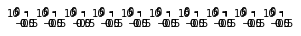

In [15]:
#what the heck does this look like now?
X = 5
y = 40
plt.figure(figsize=(X,y))
columns = 10
for x in range(0, 10):
    plt.subplot(len(segments) / columns + 1, columns, x + 1)
    plt.imshow(segments[x][0]*255,cmap='gray')
#plt.imshow(segments[0][0] * 255, cmap='gray')

In [16]:
labels.shape

(18938,)

In [17]:
labels = labels.reshape(labels.shape[0],1)
labels.shape

(18938, 1)

# Breaking apart training and test data

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(segments, labels, test_size=0.1, random_state=42)

In [19]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (17044, 9, 7, 1)
x_test shape: (1894, 9, 7, 1)
y_train shape: (17044, 1)
y_test shape: (1894, 1)


In [20]:
y_train_mod = ks.utils.to_categorical(y_train, NUM_CLASSES)
y_test_mod = ks.utils.to_categorical(y_test, NUM_CLASSES)
input_shape = (9,7,1)


In [21]:
import datetime
import time
from keras.layers import Dense, Dropout, Conv2D, Flatten, Activation, MaxPooling2D

# Gets the precision of the different metrics
def create_class_predictions(pred):
    retval = np.array([])
    for row in pred:
        max_value = (-1,-1)
        for index, value in enumerate(row):
            if value > max_value[1]:
                max_value = (index, value)
        retval = np.append(retval, max_value[0])
    return retval


def create_layers(num_layers):
    layers = [Flatten(), Dropout(0.2), Dense(NUM_CLASSES, activation='softmax', input_dim=2)]
    for i in range(0, num_layers):
        layers.insert(0, Conv2D(44, 7, input_shape=input_shape, activation='relu', padding='same'))
    return layers

# RNN Model

In [22]:
shape = x_train.shape
print("x_train shape:", shape)
x_train = x_train.reshape(shape[0], shape[1], shape[2], shape[3], 1)
print("x_train new shape:", x_train.shape)

shape = x_test.shape
print("x_test shape:", shape)
x_test = x_test.reshape(shape[0], shape[1], shape[2], shape[3], 1)
print("x_test new shape:", x_test.shape)


x_train shape: (17044, 9, 7, 1)
x_train new shape: (17044, 9, 7, 1, 1)
x_test shape: (1894, 9, 7, 1)
x_test new shape: (1894, 9, 7, 1, 1)


In [23]:
input_shape = (9, 7, 1, 1)
conv_output_shape = (1, 7, 1, 44)

model = Sequential()

model.add(ConvLSTM2D(44, 7, input_shape=input_shape, activation='relu', padding='same'))
model.add(Reshape(conv_output_shape))
model.add(ConvLSTM2D(44, 4, activation='relu', padding='same'))
model.add(Reshape(conv_output_shape))
model.add(ConvLSTM2D(44, 4, activation='relu', padding='same'))
model.add(Reshape(conv_output_shape))
model.add(ConvLSTM2D(44, 7, activation='relu', padding='same'))
model.add(Flatten())
model.add(Dropout(0.2)) 
model.add(Dense(44))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss=ks.losses.categorical_crossentropy,
        optimizer=ks.optimizers.Adam(lr=0.0001),
        metrics=['accuracy'])
print(model.summary())
model.fit(x=x_train, y=y_train_mod, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
score = model.evaluate(x_train, y_train_mod, verbose=1)
predictions = model.predict(x_test)
predict = create_class_predictions(predictions)
recall = recall_score(y_test.reshape(-1,), predict)
print("RECALL:",recall)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 7, 1, 44)          388256    
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 7, 1, 44)       0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 7, 1, 44)          247984    
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 7, 1, 44)       0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 7, 1, 44)          247984    
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 7, 1, 44)       0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 7, 1, 44)          759088    
__________

KeyboardInterrupt: 

In [ ]:
predictions = model.predict(x_test)
print(predictions)



In [26]:
shape = x_train.shape
print("x_train shape:", shape)
x_train = x_train.reshape(shape[0], shape[1], shape[2])
print("x_train new shape:", x_train.shape)

shape = x_test.shape
print("x_test shape:", shape)
x_test = x_test.reshape(shape[0], shape[1], shape[2])
print("x_test new shape:", x_test.shape)

x_train shape: (17044, 9, 7, 1, 1)
x_train new shape: (17044, 9, 7)
x_test shape: (1894, 9, 7, 1, 1)
x_test new shape: (1894, 9, 7)


In [28]:
input_shape = (9, 7)
conv_output_shape = (1, 7, 1, 44)

model = Sequential()

model.add(LSTM(NUM_CLASSES, dropout=0.2, input_shape=input_shape))
model.add(Reshape((1, 2)))
model.add(LSTM(NUM_CLASSES, dropout=0.2))
model.add(Reshape((1, 2)))
model.add(LSTM(NUM_CLASSES, dropout=0.2))
Dense(NUM_CLASSES, activation='softmax', input_dim=2)
model.compile(loss=ks.losses.categorical_crossentropy,
        optimizer=ks.optimizers.Adam(lr=0.0001),
        metrics=['accuracy'])
model.build()
print(model.summary())
model.fit(x=x_train, y=y_train_mod, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
score = model.evaluate(x_train, y_train_mod, verbose=1)
predictions = model.predict(x_test)
predict = create_class_predictions(predictions)
recall = recall_score(y_test.reshape(-1,), predict)
print("RECALL:",recall)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 2)                 80        
_________________________________________________________________
reshape_4 (Reshape)          (None, 1, 2)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 2)                 40        
_________________________________________________________________
reshape_5 (Reshape)          (None, 1, 2)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 2)                 40        
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
17044/17044 [==============================] - 17s 1ms/step - loss: nan - acc: 0.9952
Epoch 2/100
17044/17044 [================

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [ ]:
# Gets the precision of the different metrics
def create_class_predictions(pred):
    retval = np.array([])
    for row in pred:
        max_value = (-1,-1)
        for index, value in enumerate(row):
            if value > max_value[1]:
                max_value = (index, value)
        retval = np.append(retval, max_value[0])
    return retval

predict = create_class_predictions(predictions)
recall = recall_score(y_test.reshape(-1,), predict)
print(recall)
print(predict)
print(y_test.reshape(-1,))
y = y_test.reshape(-1,)
for i in range(0, len(predict)):
    if predict[i] == y[i]:
        print(y[i])
#     else:
#         print("y={}, p={}".format(y[i], predict[i]))

## Save the model for deployment

In [ ]:
# ignoring dropout for deployment
K.set_learning_phase(0)
 
# Set a file path to save the model in.
model_name = "rnn_detection_model"
model_version = "1"
tf_path = "./../../saved_models/{}/{}".format(model_name, model_version)
 
# Get the session from the Keras back-end to save the model in TF format.
with K.get_session() as sess:
    tf.saved_model.simple_save(sess, tf_path, inputs={'input': model.input}, outputs={t.name: t for t in model.outputs})
